In [65]:
import pickle
import numpy as np
import re
import matplotlib.pyplot as plt

files = {
    "ensemble": {
        "test-tqa": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/2024-05-14T14-48-57/tqa_results_test.pkl",
        "train-tqa": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/2024-05-14T14-48-57/tqa_results_train.pkl",
        "head-qa": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/2024-05-14T14-48-57/head_qa_results_test.pkl",
    },
    "base": {
        "test-tqa": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/2024-05-14T14-48-55/tqa_results_test.pkl",
        "train-tqa": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/2024-05-14T14-48-55/tqa_results_train.pkl",
        "head-qa": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/2024-05-14T14-48-55/head_qa_results_test.pkl",
    },
    "base-base": {
        "test-tqa": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/2024-05-14T19-40-41/tqa_results_test.pkl",
        "head-qa": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/2024-05-14T19-39-50/head_qa_results_test.pkl",
    },
    "single_traj": {
        "test-tqa": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/2024-05-14T18-43-11/tqa_results_test.pkl",
    },
    "no_temp": {
        "test-tqa": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/2024-05-14T18-43-02/tqa_results_test.pkl",
    }
}

results = {}
for key, val in files.items():
    result = {}
    for split, file in val.items():
        with open(file, "rb") as f:
            result[split] = pickle.load(f)
    results[key] = result

In [66]:
def lcs(x, y):
    m = len(x)
    n = len(y)
    dp = np.zeros((m + 1, n + 1), dtype=int)

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if x[i - 1] == y[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    return dp[m][n]


def measure(vals, verbose=False):
    accuracy = 0

    correct_responses = []
    incorrect_responses = []
    for _, val in vals.items():
        val["expected_response"] = re.sub(r"[^\w\s]", "", val["expected_response"])
        val["response"] = re.sub(r"[^\w\s]", "", val["response"])
        hypothesis_words = val["response"].lower().split()
        reference_words = val["expected_response"].lower().split()

        is_correct = lcs(hypothesis_words, reference_words)

        if verbose:
            print(hypothesis_words, val["expected_response"], is_correct)
        if is_correct:
            accuracy += 1
            correct_responses.append(val)
        else:
            incorrect_responses.append(val)

    return {"accuracy": accuracy / len(vals), "correct": correct_responses, "incorrect": incorrect_responses}

metrics = {}
for key, val in results.items():
    metric = {}
    for split, saved_vals in val.items():
        metric[split] = measure(saved_vals, verbose=key=="base-base")
    metrics[key] = metric

for key, val in metrics.items():
    for keyb in metrics[key].keys():
        print(key, keyb, metrics[key][keyb]["accuracy"])

['cwww'] d proving a theory 0
['dwww'] c Many scientists have agreed upon this explanation after repeated experiments and models have shown it 0
['dwww'] d all of the above 0
['b', 'a', 'chart', 'with'] b A chart with nutritional information about food we eat 4
['dwww'] d none of the above 0
['dwww'] d More than one answer is correct 0
['a', 'the', 'amount', 'of'] a The amount of damage each building receives 4
['d', 'explanation', 'a'] a A theory can never be disproven 1
['dwww'] d all of the above 0
['dwww'] d All of the above 0
['bwww'] b You should tie back your hair if it is long 0
['dwww'] e physical model 0
['awww'] a control 0
['bwww'] d independent variable 0
['a', 'true', 'explanation'] b false 0
['fwww'] f theory 0
['a', 'true', 'explanation'] b false 0
['cwww'] g scientific method 0
['cwww'] c hypothesis 0
['a', 'true'] a true 2
['bwww'] b dependent variable 0
['a', 'true', 'explanation'] a true 2
['a', 'true', 'explanation'] b false 0
['a', 'true', 'explanation'] a true 2


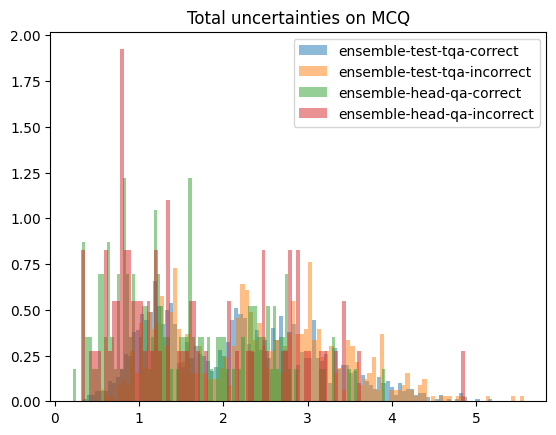

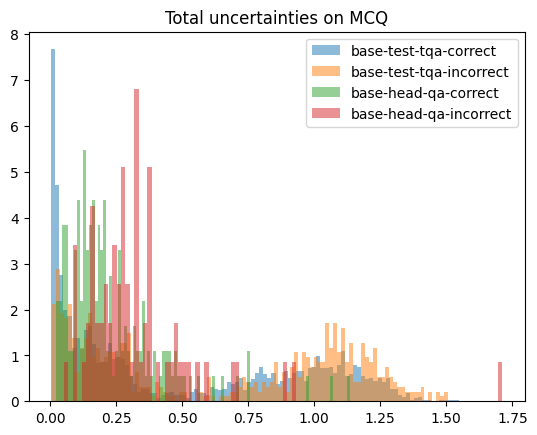

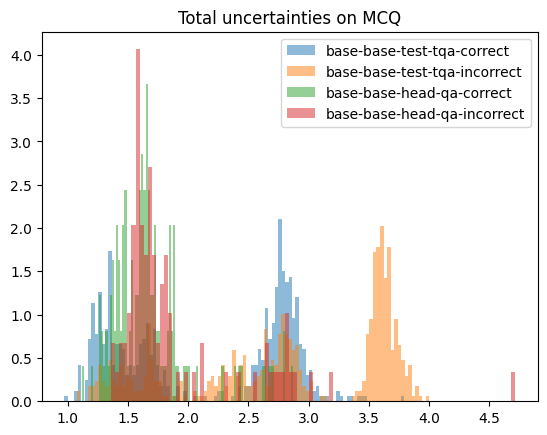

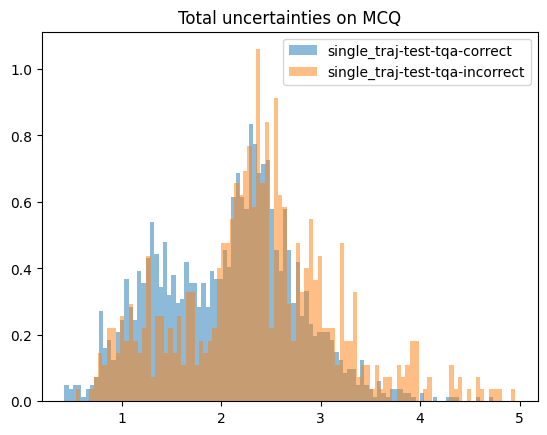

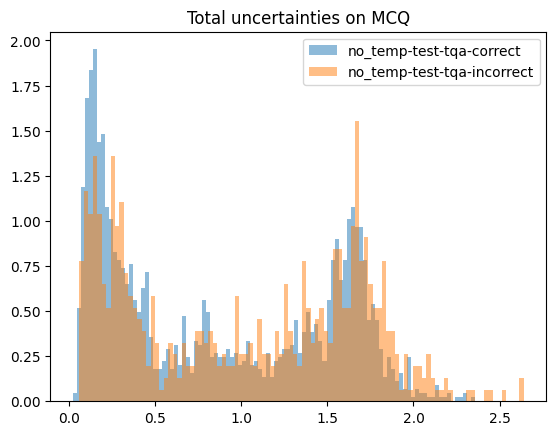

In [71]:
for model_type, d in metrics.items():
    if model_type not in ["ensemble", "base", "base-base", "single_traj", "no_temp"]:
        continue

    plt.figure()
    for key in ["test-tqa", "head-qa"]:
        if key not in d:
            continue

        for keyb in ["correct", "incorrect"]:
            responses = d[key][keyb]
    
            total_uncertainty = []
            for response in responses:
                total_uncertainty.append(np.average(response["total_uncertainty"]))

            plt.hist(total_uncertainty, bins=100, density=True, label=f"{model_type}-{key}-{keyb}", alpha=0.5)

    plt.legend()
    plt.title("Total uncertainties on MCQ")

<Figure size 640x480 with 0 Axes>

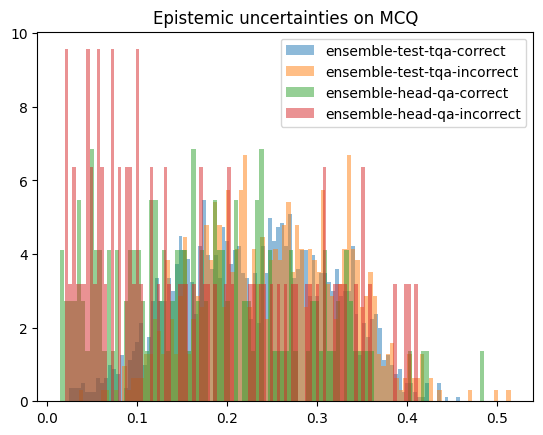

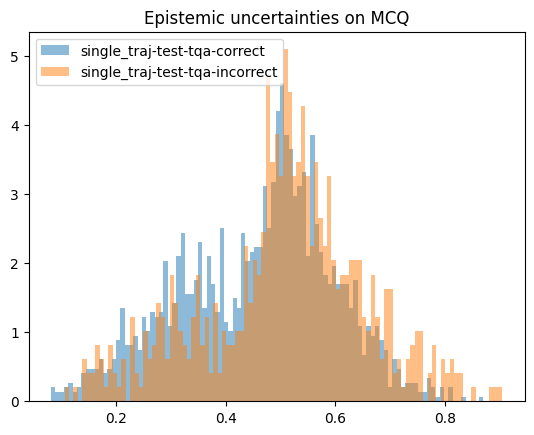

In [70]:
plt.figure()

for model_type, d in metrics.items():
    if model_type not in ["ensemble", "single_traj"]:
        continue

    plt.figure()
    for key in ["test-tqa", "head-qa"]:
        if key not in d:
            continue

        for keyb in ["correct", "incorrect"]:
            responses = d[key][keyb]
    
            total_uncertainty = []
            for response in responses:
                total_uncertainty.append(np.average(response["aleatoric_uncertainty"]))

            plt.hist(total_uncertainty, bins=100, density=True, label=f"{model_type}-{key}-{keyb}", alpha=0.5)

    plt.legend()
    plt.title("Epistemic uncertainties on MCQ")